<a href="https://colab.research.google.com/github/Sammy-Sasaki/SammyAIT23/blob/main/Assessment6Sasaki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from urllib.request import urlretrieve
import numpy as np
import random
import sys
import re, cgi
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [2]:
# Great Gatsby
url_book="https://www.gutenberg.org/files/64317/64317-0.txt"
# url_book="https://www.gutenberg.org/cache/epub/1342/pg1342.txt"
urlretrieve(url_book, 'book.txt')
text = open("book.txt", encoding='utf-8').read().lower()

# Moby Dick
url_book2="https://www.gutenberg.org/files/84/84-0.txt"
# url_book2="https://www.gutenberg.org/cache/epub/37106/pg37106.txt"
urlretrieve(url_book2, 'book2.txt')
text2 = open("book2.txt", encoding='utf-8').read().lower()

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

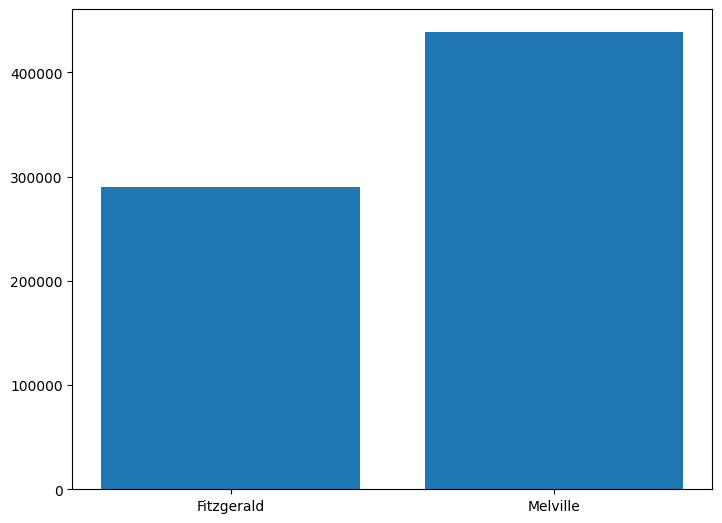

In [3]:
count1 = len(text)
count2 = len(text2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
authors = ["Fitzgerald", "Melville"]
counts = [count1, count2]
ax.bar(authors,counts)
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [4]:
sequence_length = 80
step = 10
chars = sorted(list(set(text + text2)))
alphabet_length = len(chars)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [5]:
sequences1 = []
sequences2 = []
for i in range(0, len(text)-sequence_length, step):
    sequences1.append(text[i:i + sequence_length])
for i in range(0, len(text2) - sequence_length, step):
    sequences2.append(text2[i:i + sequence_length])

In [6]:
print(len(sequences1))

28986


In [7]:
X1 = np.zeros((len(sequences1), sequence_length, alphabet_length))
Y1 = np.zeros((len(sequences1), 2))
X2 = np.zeros((len(sequences2), sequence_length, alphabet_length))
Y2 = np.zeros((len(sequences2), 2))

In [8]:
print(X1.shape, X2.shape)

(28986, 80, 72) (43863, 80, 72)


In [9]:
for i, sequence in enumerate(sequences1):
    for t, char in enumerate(sequence): 
        X1[i,t,char_indices[char]] = 1
    Y1[i][0] = 1

for i, sequence in enumerate(sequences2):
    for t, char in enumerate(sequence): 
        X2[i,t,char_indices[char]] = 1
    Y2[i][1] = 1

## Data splitting
Split the data into train, validate and test sets. Make 

In [10]:
valid_point = int(0.7*len(X1))
test_point = int(0.9*len(X1))
X1_train, Y1_train = X1[:valid_point], Y1[:valid_point]
X1_valid, Y1_valid = X1[valid_point:test_point], Y1[valid_point:test_point]
X1_test, Y1_test = X1[test_point:], Y1[test_point:]

valid_point2 = int(0.7*len(X2))
test_point2 = int(0.9*len(X2))
X2_train, Y2_train = X2[:valid_point2], Y2[:valid_point2]
X2_valid, Y2_valid = X2[valid_point2:test_point2], Y2[valid_point2:test_point2]
X2_test, Y2_test = X2[test_point2:], Y2[test_point2:]

X_train = np.concatenate((X1_train, X2_train),axis=0)
X_valid = np.concatenate((X1_valid, X2_valid),axis=0)
X_test = np.concatenate((X1_test, X2_test),axis=0)
Y_train = np.concatenate((Y1_train, Y2_train),axis=0)
Y_valid = np.concatenate((Y1_valid, Y2_valid),axis=0)
Y_test = np.concatenate((Y1_test, Y2_test),axis=0)

In [11]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(50994, 80, 72) (50994, 2)
(14569, 80, 72) (14569, 2)
(7286, 80, 72) (7286, 2)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1])))
model.add(Dense(2))
model.add(Activation("sigmoid"))

## Model training
Train the model and apply early stopping.

In [13]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [14]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [15]:
model.fit(X_train, Y_train, 
          validation_data=(X_valid,Y_valid),
          batch_size=128,                             
          epochs=50, 
          verbose=1, 
          callbacks=[es])

Epoch 1/50
399/399 [==============================] - 13s 13ms/step - loss: 0.5222 - accuracy: 0.7386 - val_loss: 0.4469 - val_accuracy: 0.7950
Epoch 2/50
399/399 [==============================] - 4s 10ms/step - loss: 0.4479 - accuracy: 0.7954 - val_loss: 0.4770 - val_accuracy: 0.7846
Epoch 3/50
399/399 [==============================] - 4s 10ms/step - loss: 0.4331 - accuracy: 0.8023 - val_loss: 0.4231 - val_accuracy: 0.8066
Epoch 4/50
399/399 [==============================] - 4s 10ms/step - loss: 0.3780 - accuracy: 0.8307 - val_loss: 0.3862 - val_accuracy: 0.8362
Epoch 5/50
399/399 [==============================] - 4s 9ms/step - loss: 0.3351 - accuracy: 0.8539 - val_loss: 0.3383 - val_accuracy: 0.8447
Epoch 6/50
399/399 [==============================] - 4s 10ms/step - loss: 0.2963 - accuracy: 0.8736 - val_loss: 0.3472 - val_accuracy: 0.8456
Epoch 7/50
399/399 [==============================] - 4s 9ms/step - loss: 0.2610 - accuracy: 0.8886 - val_loss: 0.3469 - val_accuracy: 0.8584


## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [16]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

228/228 [==============================] - 1s 4ms/step - loss: 0.8760 - accuracy: 0.6806
Test loss: 0.875995934009552
Test accuracy: 0.6806203722953796


## Confusion matrix
Calculate and display the confusion matrix.

228/228 [==============================] - 1s 3ms/step


<Axes: >

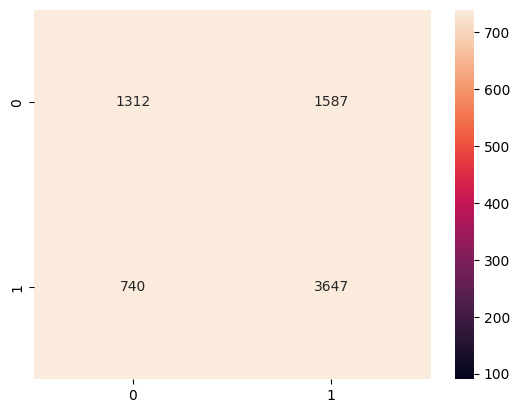

In [17]:
preds = model.predict(X_test)
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)